# CUSTOMER SEGMENTATION

In this notebook, I will try to analyze shopping data to group customers based on their preferences for different products and store departments. By using PCA, a powerful technique that simplifies data, I reveal patterns that help businesses understand their customers better. With this knowledge, retailers can improve their strategies and offer personalized experiences, leading to happier customers and increased success.I will then try to find possible explanations for the identified clusters.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA


## Read Data

In [10]:
aisles = pd.read_csv('data/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
department = pd.read_csv('data/departments.csv')
department.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [12]:
product = pd.read_csv('data/products.csv')
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
order = pd.read_parquet('data/order.parquet', columns = ['order_id', 'user_id', 'order_number','days_since_prior_order'])
order.head()

,order_id,user_id,order_number,days_since_prior_order
0,2539329,1,1,NaN
1,2398795,1,2,15.0
2,473747,1,3,21.0
3,2254736,1,4,29.0
4,431534,1,5,28.0


In [14]:
order_prior_files = ['data/order_prior1.parquet',
                     'data/order_prior2.parquet']

df = pd.concat((pd.read_parquet(f, columns= ['order_id', 'product_id']) for f in order_prior_files))
print(df.shape)
df.head()

(32434489, 2)


,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035


## Data Cleaning

Combining multiple data sources into a single table is needed to simplify data exploration.

In [15]:
product = pd.merge(product,aisles, how = 'inner', on = 'aisle_id')
product = pd.merge(product,department, how = 'inner', on = 'department_id')
product = product[['product_id', 'product_name', 'aisle', 'department']]
print(product.shape)
product.head()

(49688, 4)


,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [16]:
#main df
df = pd.merge(df,product, how='inner', on = 'product_id' )
df = pd.merge(df,order, how='inner', on = 'order_id')
print(df.shape)
df.head()

(32434489, 8)


,order_id,product_id,product_name,aisle,department,user_id,order_number,days_since_prior_order
0,2,33120,Organic Egg Whites,eggs,dairy eggs,202279,3,8.0
1,2,28985,Michigan Organic Kale,fresh vegetables,produce,202279,3,8.0
2,2,9327,Garlic Powder,spices seasonings,pantry,202279,3,8.0
3,2,45918,Coconut Butter,oils vinegars,pantry,202279,3,8.0
4,2,30035,Natural Sweetener,baking ingredients,pantry,202279,3,8.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   product_name            object 
 3   aisle                   object 
 4   department              object 
 5   user_id                 int64  
 6   order_number            int64  
 7   days_since_prior_order  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 2.2+ GB


In [18]:
df.isnull().sum()

order_id                        0
product_id                      0
product_name                    0
aisle                           0
department                      0
user_id                         0
order_number                    0
days_since_prior_order    2078068
dtype: int64

In [19]:
#check typo 
for col in ['aisle', 'department']:
  print(df[col].value_counts())

fresh fruits                  3642188
fresh vegetables              3418021
packaged vegetables fruits    1765313
yogurt                        1452343
packaged cheese                979763
                               ...   
eye ear care                     8974
baby bath body care              8581
baby accessories                 8160
beauty                           6168
frozen juice                     4853
Name: aisle, Length: 134, dtype: int64
produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
bul

Dari hasil eksplorasi diatas, kita dapat menyimpulkan terdapat 2078068 rows dari kolom days_since_prior_order yang mempunyai missing value. Nilai null tersebut kemungkinan karena merupakan pembelian pertama. Dan pada data yang dipunya juga tidak ditemukan typo pada kolom aisle dan department, yang mana sangat memungkinkan untuk ditemukan typo pada kolom kategorikal

## EDA

In [21]:
df.head()

,order_id,product_id,product_name,aisle,department,user_id,order_number,days_since_prior_order
0,2,33120,Organic Egg Whites,eggs,dairy eggs,202279,3,8.0
1,2,28985,Michigan Organic Kale,fresh vegetables,produce,202279,3,8.0
2,2,9327,Garlic Powder,spices seasonings,pantry,202279,3,8.0
3,2,45918,Coconut Butter,oils vinegars,pantry,202279,3,8.0
4,2,30035,Natural Sweetener,baking ingredients,pantry,202279,3,8.0


### Mengecek kuantitas yang terjual berdasarkan product_name

                 product_name  order_id
3676                   Banana    472565
3471   Bag of Organic Bananas    379450
31920    Organic Strawberries    264683
28840    Organic Baby Spinach    241921
30297    Organic Hass Avocado    213584
28804         Organic Avocado    176815
22413             Large Lemon    152657
42904            Strawberries    142951
23420                   Limes    140627
32478      Organic Whole Milk    137905


<Axes: xlabel='product_name', ylabel='order_id'>

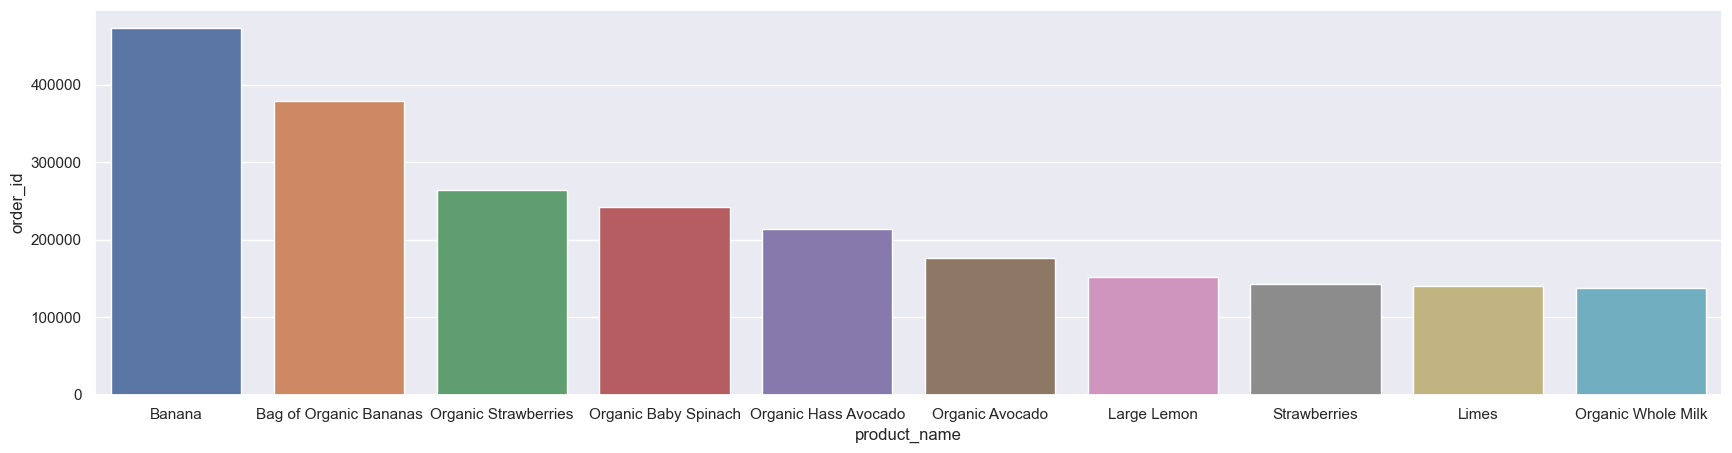

In [26]:
temp = df.groupby('product_name', as_index=False)['order_id'].count().sort_values(by ='order_id', ascending=False).head(10)
print(temp)


sns.set(rc={'figure.figsize':(21,5)})
sns.barplot(data=temp, x="product_name", y="order_id")

### Mengecek kuantitas yang terjual berdasarkan aisle

                             aisle  order_id
50                    fresh fruits   3642188
53                fresh vegetables   3418021
98      packaged vegetables fruits   1765313
133                         yogurt   1452343
93                 packaged cheese    979763
83                            milk    891015
131  water seltzer sparkling water    841533
25                  chips pretzels    722470
119                soy lactosefree    638253
11                           bread    584834


<Axes: xlabel='aisle', ylabel='order_id'>

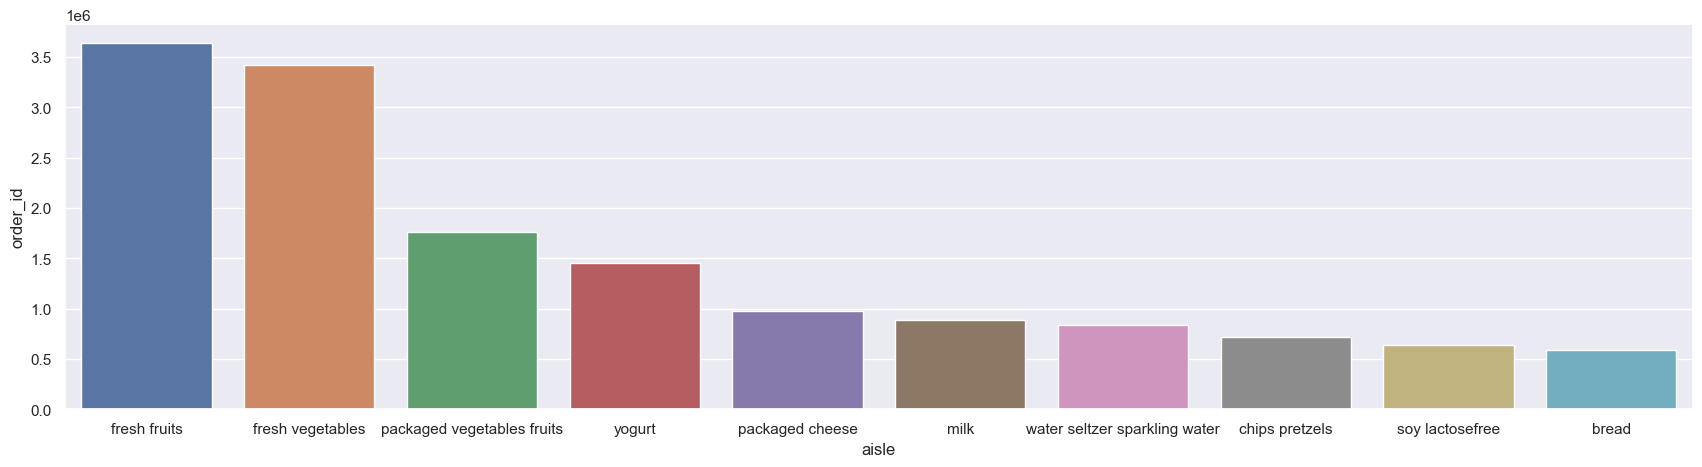

In [27]:
temp = df.groupby('aisle', as_index=False)['order_id'].count().sort_values(by ='order_id', ascending=False).head(10)
print(temp)


sns.set(rc={'figure.figsize':(21,5)})
sns.barplot(data=temp, x="aisle", y="order_id")

### Mengecek kuantitas yang terjual berdasarkan department

         department  order_id
19          produce   9479291
7        dairy eggs   5414016
20           snacks   2887550
3         beverages   2690129
10           frozen   2236432
16           pantry   1875577
2            bakery   1176787
6      canned goods   1068058
8              deli   1051249
9   dry goods pasta    866627


<Axes: xlabel='department', ylabel='order_id'>

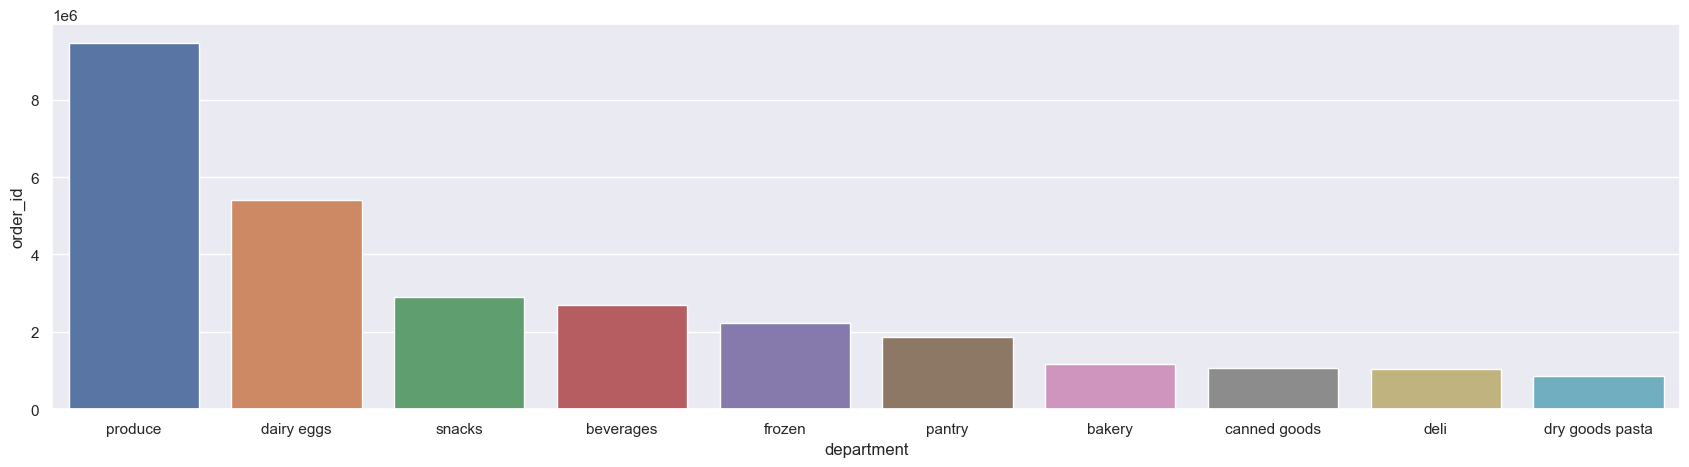

In [28]:
temp = df.groupby('department', as_index=False)['order_id'].count().sort_values(by ='order_id', ascending=False).head(10)
print(temp)


sns.set(rc={'figure.figsize':(21,5)})
sns.barplot(data=temp, x="department", y="order_id")

## RFM (Recency, Frequency, and Monetary Value)

RFM stands for Recency, Frequency, and Monetary Value. It is a popular customer segmentation technique used in marketing and retail analytics to classify customers based on their past purchasing behavior. RFM analysis helps businesses identify and target their most valuable customers and understand different customer segments.

Recency (R): This refers to how recently a customer made a purchase. Customers who have made recent purchases are often more engaged and likely to make additional purchases. Recency is typically measured by the time elapsed since the last transaction. In this data, we use Average Gap Time Buy as the Recency

Frequency (F): Frequency represents how often a customer makes purchases. Customers who make frequent purchases are often more loyal and engaged with the brand.

Monetary Value (M): Monetary Value indicates the total amount of money a customer has spent on purchases. Customers with higher monetary value are typically more profitable and valuable to the business. In this data, we use quantity instead of the monetary value.

*   Recency : Average gap time between order
*   Frequency : Order Count
*   Monetary : Quantity Item

In [29]:
order.head()

,order_id,user_id,order_number,days_since_prior_order
0,2539329,1,1,NaN
1,2398795,1,2,15.0
2,473747,1,3,21.0
3,2254736,1,4,29.0
4,431534,1,5,28.0


In [30]:
ct_item = df.groupby('user_id', as_index=False)['product_id'].count()

rfm = order.groupby('user_id', as_index=False).agg({'order_id' : 'nunique', 'days_since_prior_order': 'mean'  })
rfm = pd.merge(rfm,ct_item )
rfm = rfm.rename(columns = {'order_id': 'F', 'days_since_prior_order' : 'R', 'product_id':'M'})
rfm.head()

,user_id,F,R,M
0,1,11,19.000000,59
1,2,15,16.285714,195
2,3,13,12.000000,88
3,4,6,17.000000,18
4,5,5,11.500000,37


We create tier column for each R F M.

*  tier 1: order count & quantity item more than q3, average gap time between order less than q1
*  tier 2: order count & quantity item between q2 and q3, average gap time between between q1 and q2
*  tier 3: order count & quantity item between q1 and q2, average gap time between between q2 and q3
*  tier 4: order count & quantity item less than q1, average gap time between order more than q3

In [31]:
for col in ['R', 'F', 'M']:
  min= rfm[col].quantile(0)
  q1 = rfm[col].quantile(0.25)
  q2 = rfm[col].quantile(0.50)
  q3 = rfm[col].quantile(0.75)
  max = rfm[col].quantile(1)

  rfm.loc[(rfm[col] >= min) & (rfm[col] < q1) , f'tier_{col}'] = 4
  rfm.loc[(rfm[col] >= q1) & (rfm[col] < q2) , f'tier_{col}'] = 3
  rfm.loc[(rfm[col] >= q2) & (rfm[col] < q3) , f'tier_{col}'] = 2
  rfm.loc[(rfm[col] >= q3) & (rfm[col] <= max) , f'tier_{col}'] = 1

#because Recency lower better
rfm['tier_R'].replace({1:4,2:3,3:2,4:1}, inplace=True)

In [32]:
print(rfm.shape)
rfm.head()

(206209, 7)


,user_id,F,R,M,tier_R,tier_F,tier_M
0,1,11,19.000000,59,3.0,2.0,3.0
1,2,15,16.285714,195,3.0,2.0,1.0
2,3,13,12.000000,88,2.0,2.0,2.0
3,4,6,17.000000,18,3.0,3.0,4.0
4,5,5,11.500000,37,2.0,4.0,4.0


We add segmentation column for the combination of F R M (Higher tiers are better)

*  New Customer
*  Risky Customer
*  Churn Customer
*  Loyal Customer
*  High Spender Customer
*  Champion Customer

In [33]:
rfm.loc[rfm['tier_R'] == 4 , 'Segment'] = 'Risky Customer' 
rfm.loc[rfm['tier_F'] == 1 , 'Segment'] = 'Loyal Customer'
rfm.loc[rfm['tier_M'] == 1 , 'Segment'] = 'High Spender Customer'

rfm.loc[(rfm['tier_F'] == 1) & (rfm['tier_M'] == 3) , 'Segment'] = 'Potential Customer'
rfm.loc[(rfm['tier_F'] == 1) & (rfm['tier_M'] == 4) , 'Segment'] = 'Potential Customer'

rfm.loc[(rfm['tier_R'] == 1) & (rfm['tier_F'] == 3) , 'Segment'] = 'New Customer' 
rfm.loc[(rfm['tier_R'] == 1) & (rfm['tier_F'] == 4) , 'Segment'] = 'New Customer'

rfm.loc[(rfm['tier_R'] == 4) & (rfm['tier_F'] == 4) , 'Segment'] = 'Churn Customer'

rfm.loc[(rfm['tier_R'] == 1) & (rfm['tier_F'] == 1) & (rfm['tier_M'] == 1) , 'Segment'] = 'Champion'
rfm.loc[(rfm['tier_R'] == 1) & (rfm['tier_F'] == 2) & (rfm['tier_M'] == 1) , 'Segment'] = 'Champion'
rfm.loc[(rfm['tier_R'] == 2) & (rfm['tier_F'] == 1) & (rfm['tier_M'] == 1) , 'Segment'] = 'Champion'
rfm.loc[(rfm['tier_R'] == 2) & (rfm['tier_F'] == 2) & (rfm['tier_M'] == 1) , 'Segment'] = 'Champion'

rfm = rfm.fillna('other')

In [34]:
rfm.sample(5)

,user_id,F,R,M,tier_R,tier_F,tier_M,Segment
39993,39994,32,11.354839,313,2.0,1.0,1.0,Champion
167527,167528,49,7.354167,355,1.0,1.0,1.0,Champion
659,660,10,21.444444,108,4.0,2.0,2.0,at Risk
126142,126143,11,16.700000,200,3.0,2.0,1.0,Big Spender
144909,144910,5,15.000000,56,3.0,4.0,3.0,other


## Clustering